# Analysis of Split ECG latent space for Model Poisoning Detection

In [1]:
import numpy as np
import os
from torch.nn.functional import max_pool1d, avg_pool1d
import torch
import pickle
import pandas as pd
import scipy.spatial as sp
from scipy.interpolate import make_interp_spline, BSpline
from scipy.special import kl_div, rel_entr
from scipy.stats import skewnorm, norm
from scipy.spatial.distance import jensenshannon
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier, KernelDensity
from sklearn.decomposition import PCA
from functools import partial
import multiprocessing
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib as mpl
from contextlib import closing
import itertools
#from tqdm.notebook import tqdm
from tqdm import tqdm
import math
from server.security.analysis import *
import client.utils as utils
%load_ext autoreload
%autoreload 2

In [85]:
epochs = 30
N = 10
M = 4
p = 0.55
iid = False
base_path = f"/home/mohkoh/projects/Split_ECG_Classification/latent_space/IID={iid}_N={N}_M={M}_type=LF_p={p}"
metadata = pickle.load(open(os.path.join(base_path, "metadata.pickle"), "rb"))

epoch = 5
kde_params = {
    "kernel": "gaussian",
    #"metric": "seuclidean",
    "bandwidth": .4
}
pca_params = {
    "n_components": 24
}

knn_params = {
    "n_neighbors": 15, 
    "metric": "seuclidean"
}

sigma = 4.0

split="knn_10_euclidean"
# split="dec"
pooling="max"
        
metadata

{'num_clients': 10,
 'exp_name': 'IID=False_N=10_M=4_type=LF_p=0.55',
 'is_malicious': {0: False,
  1: False,
  2: True,
  4: True,
  5: False,
  6: False,
  7: False,
  8: True,
  9: True,
  3: False},
 'batchsize': 64,
 'data_poisoning_prob': 0.0,
 'label_flipping_prob': 0.55}

In [3]:
df_base = pd.DataFrame()
for idx in tqdm(range(N), desc=f"Load Data Frames"):
    for epoch in range(1, epochs + 1):
        client_path = os.path.join(base_path, 
                                   "client_" + str(idx))
        df = pd.read_pickle(os.path.join(client_path, "epoch_{}.pickle".format(epoch)))
        df["client_id"] = idx
        df_base = pd.concat([df_base, df], axis=0, ignore_index=True)

Load Data Frames:   0%|          | 0/10 [00:00<?, ?it/s]

## Density Difference Analysis

In [123]:
def per_class_kde(df_base, client_id, epoch, kde_params, split="knn_10_euclidean", pooling=None, pca_params=None):
    
    # Pre-Process Data
    df1 = df_base[(df_base["client_id"] == client_id) & (df_base["epoch"] == epoch)]
    df1 = split_labels(df1, split)
    
    # Get high dimensional vectors
    hd = pool_latent_vectors(df1.client_output.to_list(), pooling=pooling)
    
    # Get lower dimensional vectors if pca is used
    if pca_params and pooling is None:
        pca = PCA(**pca_params).fit(hd)
        ld = pca.transform(hd)
    else:
        ld = hd
        
    # Insert back to dataframe
    df1.client_output = ld.tolist()
    labels = df1.label.unique()
    
    # Estimate densities
    p = KernelDensity(**kde_params).fit(ld)
    p_k = {}
    for k in labels:
        p_k[k] = np.exp(p.score_samples(df1[df1.label == k].client_output.to_list())).sum()
        
    print(df1.label.value_counts() / len(df1))
    print(pd.Series(p_k))

    return p_k, labels

def rolling_density_diff(df_base, N, epoch, kde_params, split="knn_10_euclidean", pooling=None, pca_params=None, ref=None):
    df_plot = pd.DataFrame(columns=["epoch", "client_id", "label", "re", "kl", "sre", "skl"])
    
    if ref is not None:
        old_p_k, _ = per_class_kde(df_base, ref, epoch, kde_params, split=split, pooling=pooling, pca_params=pca_params)
    else:
        old_p_k = None
        
    for client_id in range(N):
        # print(f"-------------------")
        # print(f"ID: {client_id}")
        
        p_k, labels = per_class_kde(df_base, client_id, epoch, kde_params, split=split, pooling=pooling, pca_params=pca_params)
        
        for k in labels:
            if old_p_k is not None:
                p = old_p_k[k]
                q = p_k[k]
                
                kl = kl_div(p, q)
                re = rel_entr(p, q)
                skl = kl + kl_div(q, p)
                sre = re + rel_entr(q, p)
                td = [re, kl, sre, skl]
                
            else:
                td = [0., 0., 0., 0.]
            df_plot.loc[len(df_plot)] = [epoch, client_id, k, *td]
            # print(f"--- Temporal Divergence {k}: \t RE: {td[0]:.2f} | KLD: {td[1]:.2f} | SRE: {td[2]:.2f} | SKLD: {td[3]:.2f}")
        
        old_p_k = p_k if ref is None else old_p_k
        # print(f"-------------------\n")
        
    return df_plot

In [140]:

df_plot = rolling_density_diff(df_base, N, epoch, kde_params, split=split, pooling=pooling, pca_params=None, ref=3)

2.00    0.48
4.00    0.21
1.00    0.17
16.00   0.11
8.00    0.03
Name: label, dtype: float64
2.00    0.45
16.00   0.11
4.00    0.20
8.00    0.02
1.00    0.16
dtype: float64
2.00    0.49
4.00    0.20
1.00    0.18
16.00   0.11
8.00    0.03
Name: label, dtype: float64
1.00    0.17
2.00    0.46
4.00    0.18
16.00   0.10
8.00    0.02
dtype: float64
2.00    0.53
4.00    0.18
1.00    0.17
16.00   0.10
8.00    0.03
Name: label, dtype: float64
2.00    0.50
1.00    0.16
16.00   0.09
4.00    0.16
8.00    0.03
dtype: float64
2.00    0.53
4.00    0.18
1.00    0.17
16.00   0.10
8.00    0.03
Name: label, dtype: float64
2.00    0.50
1.00    0.16
4.00    0.17
16.00   0.10
8.00    0.02
dtype: float64
2.00    0.48
4.00    0.21
1.00    0.17
16.00   0.11
8.00    0.03
Name: label, dtype: float64
2.00    0.45
16.00   0.11
4.00    0.20
8.00    0.02
1.00    0.16
dtype: float64
2.00    0.54
4.00    0.18
1.00    0.16
16.00   0.10
8.00    0.03
Name: label, dtype: float64
2.00    0.50
16.00   0.10
4.00    0.17
1.0

### p = 0.25

#### M = 2

label
1.00     AxesSubplot(0.125,0.11;0.775x0.77)
2.00     AxesSubplot(0.125,0.11;0.775x0.77)
4.00     AxesSubplot(0.125,0.11;0.775x0.77)
8.00     AxesSubplot(0.125,0.11;0.775x0.77)
16.00    AxesSubplot(0.125,0.11;0.775x0.77)
Name: skl, dtype: object

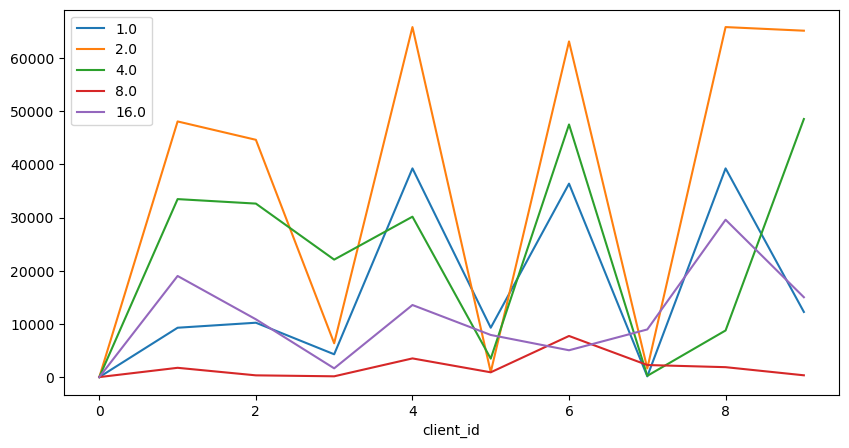

In [136]:
df_plot.set_index("client_id").groupby("label")["skl"].plot(legend=True, figsize=(10, 5))

#### M = 6

In [73]:
df_plot.groupby("client_id")["sre"].sum()

client_id
0.0    0.000000e+00
1.0    1.634179e-12
2.0    1.462622e-12
3.0    4.216928e-13
4.0    1.958464e-12
5.0    6.023371e-13
6.0    2.439683e-12
7.0    2.448329e-13
8.0    1.949417e-12
9.0    1.569005e-12
Name: sre, dtype: float64

label
1.0     AxesSubplot(0.125,0.11;0.775x0.77)
2.0     AxesSubplot(0.125,0.11;0.775x0.77)
4.0     AxesSubplot(0.125,0.11;0.775x0.77)
8.0     AxesSubplot(0.125,0.11;0.775x0.77)
16.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: skl, dtype: object

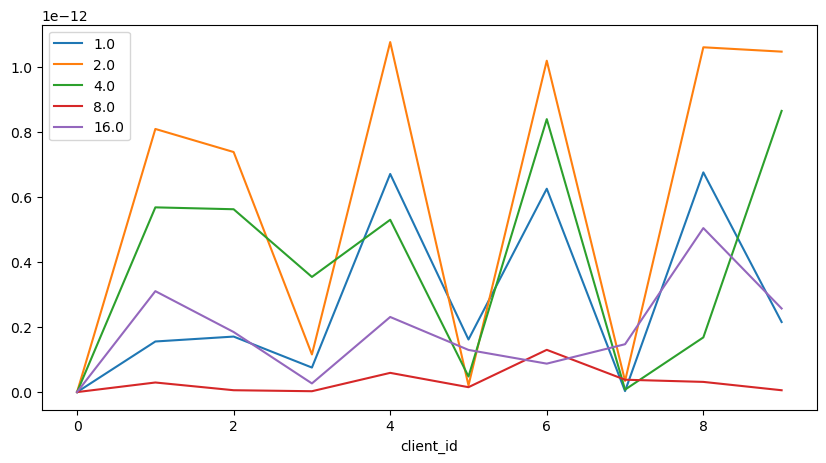

In [92]:
df_plot.set_index("client_id").groupby("label")["skl"].plot(legend=True, figsize=(10, 5))

<AxesSubplot:xlabel='client_id'>

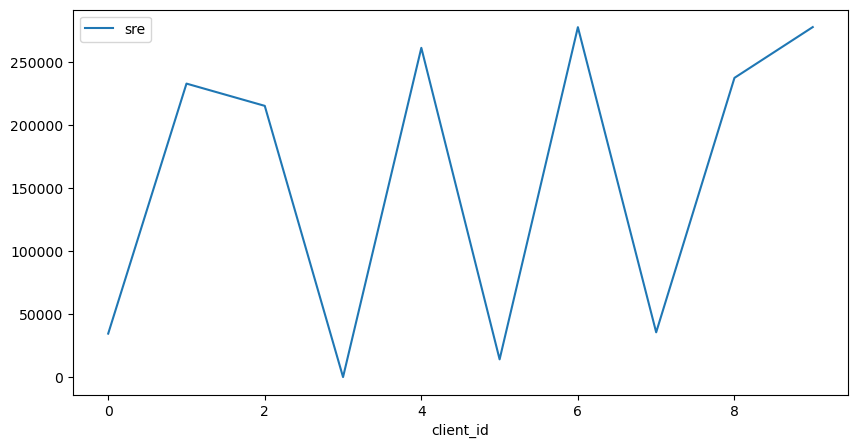

In [139]:
df_plot.groupby("client_id").sum()["sre"].plot(legend=True, figsize=(10, 5))

## k-NN based approach (no density estimation)

In [84]:
df_clients = client_scores(num_clients=metadata["num_clients"], num_workers=multiprocessing.cpu_count(), df_base=df_base[df_base.stage == "train"], epochs=epochs, method="membership", pooling=pooling, split=split, pca_params=None, knn_params=knn_params, sigma=sigma)

|Client x Epoch|:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
df_plot = rolling_membership_diff(df_clients[df_clients.client_id.isin([0, 3, 5, 7])], ref=7)
df_plot["cum_div"] = df_plot.groupby("client_id")["skl"].transform(pd.Series.cumsum)
df_plot = df_plot.apply(lambda x: exp_decay(x), axis=1)
df_plot["cum_div"][df_plot["cum_div"] < 0] = 0
#df_plot["cum_div"] = df_plot.groupby("epoch")["cum_div"].transform(lambda x: 1 - np.exp(-x**2))
df_plot[df_plot.epoch < 30].set_index("epoch").groupby("client_id")["cum_div"].plot(legend=True, figsize=(10, 5))

In [19]:
%reload_ext autoreload

<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.fl

client_id
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cum_div, dtype: object

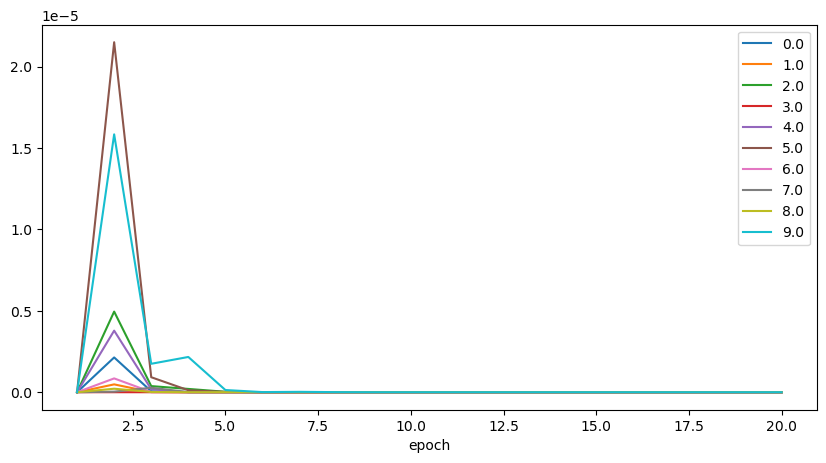

In [179]:
df_plot = rolling_membership_diff_non_iid(df_clients, ref=None, method="kernel")
#df_plot["cum_div"] = df_plot.groupby("client_id")["skl"].transform(pd.Series.cumsum)
# df_plot["cum_div"] = df_plot.groupby("client_id")["skl"].transform(lambda x: x.rolling(window=20, min_periods=0, center=False).sum())
df_plot["cum_div"] = df_plot.groupby("client_id")["skl"].transform(lambda x: x.ewm(halflife=15).sum())
df_plot = df_plot.apply(lambda x: exp_decay(x), axis=1)
df_plot["cum_div"][df_plot["cum_div"] < 0] = 0
#df_plot["cum_div"] = df_plot.groupby("epoch")["cum_div"].transform(lambda x: 1 - np.exp(-x**2))
df_plot[df_plot.epoch < 30].set_index("epoch").groupby("client_id")["cum_div"].plot(legend=True, figsize=(10, 5))

client_id
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
6    AxesSubplot(0.125,0.11;0.775x0.77)
7    AxesSubplot(0.125,0.11;0.775x0.77)
8    AxesSubplot(0.125,0.11;0.775x0.77)
9    AxesSubplot(0.125,0.11;0.775x0.77)
Name: kernel, dtype: object

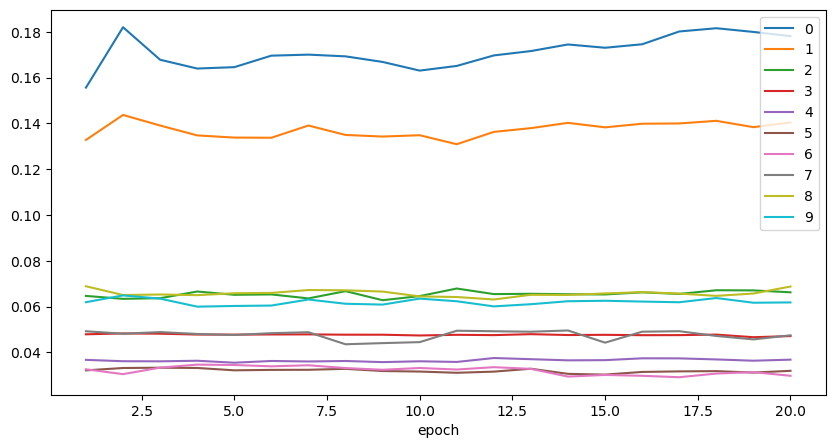

In [24]:
df_client = df_clients[df_clients.label == 2].sort_values("epoch")
df_client.kernel = (df_clients.kernel / df_clients.num_samples) * 100
df_client.set_index("epoch").groupby("client_id")["kernel"].plot(legend=True, figsize=(10, 5))

client_id
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cum_div, dtype: object

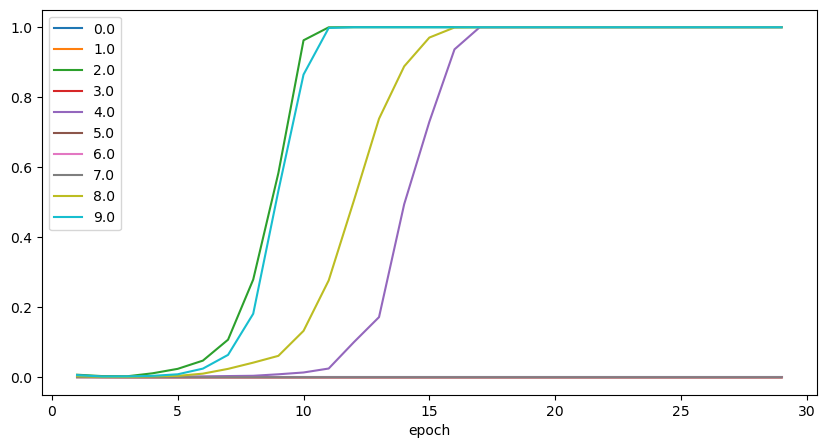

In [31]:
df_plot = rolling_membership_diff(df_clients, ref=None, method="kernel")
#df_plot["cum_div"] = df_plot.groupby("client_id")["skl"].transform(pd.Series.cumsum)
# df_plot["cum_div"] = df_plot.groupby("client_id")["skl"].transform(lambda x: x.rolling(window=20, min_periods=0, center=False).sum())
df_plot["cum_div"] = df_plot.groupby("client_id")["skl"].transform(lambda x: x.ewm(halflife=30).sum())
df_plot = df_plot.apply(lambda x: exp_decay(x), axis=1)
df_plot["cum_div"][df_plot["cum_div"] < 0] = 0
#df_plot["cum_div"] = df_plot.groupby("epoch")["cum_div"].transform(lambda x: 1 - np.exp(-x**2))
df_plot[df_plot.epoch < 30].set_index("epoch").groupby("client_id")["cum_div"].plot(legend=True, figsize=(10, 5))

#### M = 6, p = 0.75

client_id
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cumsum, dtype: object

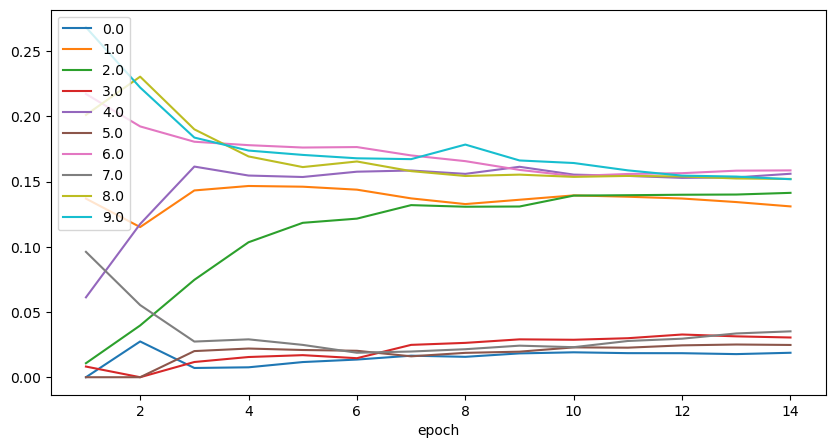

In [86]:
df_plot["cum_div"] = df_plot.groupby("client_id")["re"].transform(pd.Series.cumsum)
df_plot["cum_div"][df_plot["cum_div"] < 0] = 0
df_plot["cum_div"] = df_plot.groupby("epoch")["cum_div"].transform(lambda x: x / x.sum())
df_plot[df_plot.epoch < 15].set_index("epoch").groupby("client_id")["cum_div"].plot(legend=True, figsize=(10, 5))

#### M = 6, p = 0.25

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_2580868/1781136711.py:15: RuntimeWarning: invalid value encountered in divide
  p_k = (dY * (nY == comp[:, None])).sum(axis=1) / dY.sum(axis=1)
/tmp/ipykernel_2580868/1781136711.py:15: RuntimeWarning: invalid value encountered in divide
  p_k = (dY * (nY == comp[:, None])).sum(axis=1) / dY.sum(axis=1)
/tmp/ipykernel_2580868/1781136711.py:15: RuntimeWarning: invalid value encountered in divide
  p_k = (dY * (nY == comp[:, None])).sum(axis=1) / dY.sum(axis=1)
/tmp/ipykernel_2580868/1781136711.py:15: RuntimeWarning: invalid value encountered in divide
  p_k = (dY * (nY == comp[:, None])).sum(axis=1) / dY.sum(axis=1)
/tmp/ipykernel_2580868/1781136711.py:15: RuntimeWarning: invalid value encountered in divide
  p_k = (dY * (nY == comp[:, None])).sum(axis=1) / dY.sum(axis=1)
/tmp/ipykernel_2580868/1781136711.py:15: RuntimeWarning: invalid value encountered in divide
  p_k = (dY * (nY == comp[:, None])).sum(axis=1) / dY.sum(axis=1)
/tmp/ipykernel_2580868/1781136711.py:15: Runti

client_id
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cumsum, dtype: object

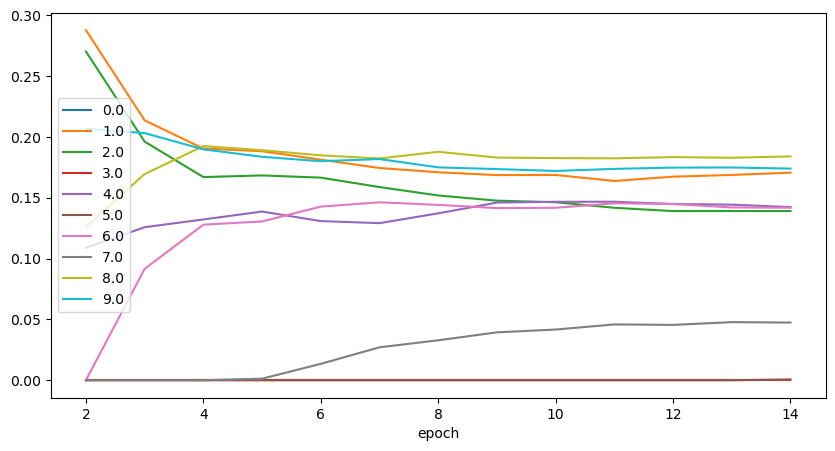

In [221]:
df_plot = pd.DataFrame()
for epoch in tqdm(range(1, epochs + 1), desc=f"Epochs"):
    df_plot = pd.concat([df_plot, rolling_membership_diff(df_base, N, epoch, method="kernel", ref=0, knn_params=knn_params, sigma=1, split="knn_10_euclidean", pooling=pooling, pca_params=pca_params)], axis=0, ignore_index=True)
df_plot["cum_div"] = df_plot.groupby("client_id")["re"].transform(pd.Series.cumsum)
df_plot["cum_div"][df_plot["cum_div"] < 0] = 0
df_plot["cum_div"] = df_plot.groupby("epoch")["cum_div"].transform(lambda x: x / x.sum())
df_plot[df_plot.epoch < 15].set_index("epoch").groupby("client_id")["cum_div"].plot(legend=True, figsize=(10, 5))

client_id
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cumsum, dtype: object

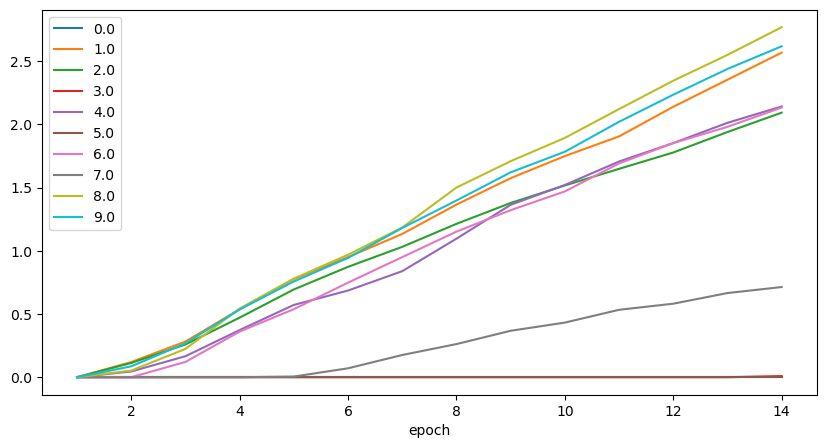

In [226]:
df_plot["cum_div"] = df_plot.groupby("client_id")["re"].transform(pd.Series.cumsum)
df_plot["cum_div"][df_plot["cum_div"] < 0] = 0
#df_plot["cum_div"] = df_plot.groupby("epoch")["cum_div"].transform(lambda x: x / x.max())
df_plot[df_plot.epoch < 15].set_index("epoch").groupby("client_id")["cum_div"].plot(legend=True, figsize=(10, 5))

#### M = 2, p = 0.25

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_2580868/1781136711.py:15: RuntimeWarning: invalid value encountered in divide
  p_k = (dY * (nY == comp[:, None])).sum(axis=1) / dY.sum(axis=1)
/tmp/ipykernel_2580868/1781136711.py:15: RuntimeWarning: invalid value encountered in divide
  p_k = (dY * (nY == comp[:, None])).sum(axis=1) / dY.sum(axis=1)
/tmp/ipykernel_2580868/1781136711.py:15: RuntimeWarning: invalid value encountered in divide
  p_k = (dY * (nY == comp[:, None])).sum(axis=1) / dY.sum(axis=1)
/tmp/ipykernel_2580868/1781136711.py:15: RuntimeWarning: invalid value encountered in divide
  p_k = (dY * (nY == comp[:, None])).sum(axis=1) / dY.sum(axis=1)
/tmp/ipykernel_2580868/1781136711.py:15: RuntimeWarning: invalid value encountered in divide
  p_k = (dY * (nY == comp[:, None])).sum(axis=1) / dY.sum(axis=1)
/tmp/ipykernel_2580868/1781136711.py:15: RuntimeWarning: invalid value encountered in divide
  p_k = (dY * (nY == comp[:, None])).sum(axis=1) / dY.sum(axis=1)
/tmp/ipykernel_2580868/1781136711.py:15: Runti

client_id
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: re, dtype: object

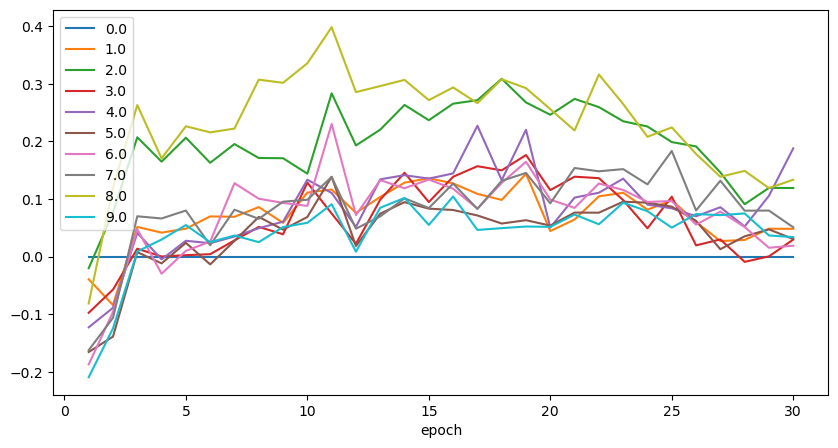

In [191]:
df_plot = pd.DataFrame()
for epoch in tqdm(range(1, epochs + 1), desc=f"Epochs"):
    df_plot = pd.concat([df_plot, rolling_membership_diff(df_base, N, epoch, method="kernel", ref=0, knn_params=knn_params, sigma=1, split="knn_10_euclidean", pooling=pooling, pca_params=pca_params)], axis=0, ignore_index=True)
df_plot["cum_div"] = df_plot.groupby("client_id")["re"].transform(pd.Series.cumsum)
df_plot["cum_div"][df_plot["cum_div"] < 0] = 0
df_plot["cum_div"] = df_plot.groupby("epoch")["cum_div"].transform(lambda x: x / x.sum())
df_plot[df_plot.epoch < 15].set_index("epoch").groupby("client_id")["cum_div"].plot(legend=True, figsize=(10, 5))

client_id
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cumsum, dtype: object

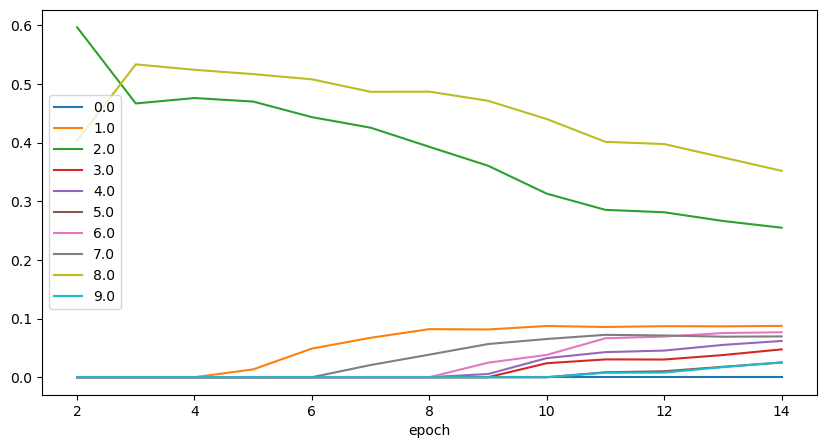

In [218]:
df_plot["cum_div"] = df_plot.groupby("client_id")["re"].transform(pd.Series.cumsum)
df_plot["cum_div"][df_plot["cum_div"] < 0] = 0
df_plot["cum_div"] = df_plot.groupby("epoch")["cum_div"].transform(lambda x: x / x.sum())
df_plot[df_plot.epoch < 15].set_index("epoch").groupby("client_id")["cum_div"].plot(legend=True, figsize=(10, 5))

In [212]:
df_plot["cum_div"]

0      0.000000
1     -0.039383
2     -0.020161
3     -0.097546
4     -0.122763
         ...   
295    1.266303
296    2.198211
297    2.514540
298    7.006675
299    1.244248
Name: cumsum, Length: 300, dtype: float64

<AxesSubplot:xlabel='client_id'>

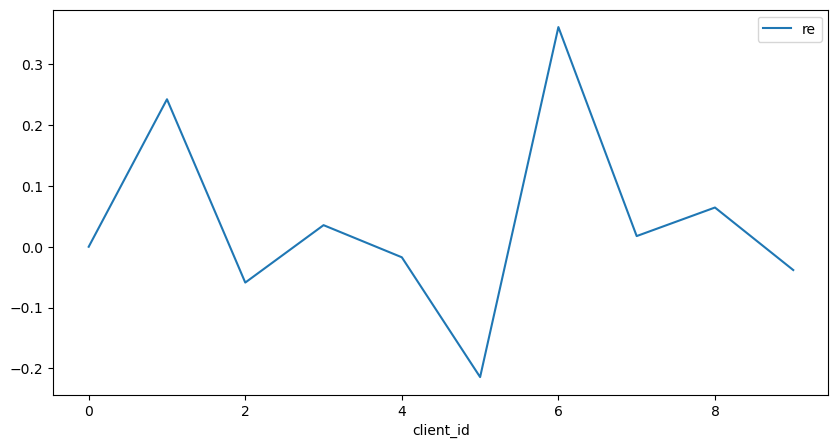

In [172]:
df_plot.set_index("client_id")["re"].plot(legend=True, figsize=(10, 5))

<AxesSubplot:xlabel='client_id'>

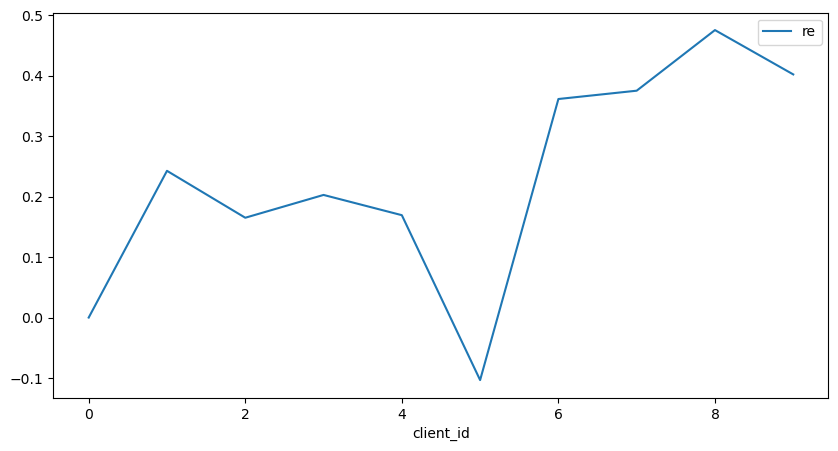

In [175]:
df_plot.set_index("client_id")["re"].plot(legend=True, figsize=(10, 5))

<AxesSubplot:xlabel='client_id'>

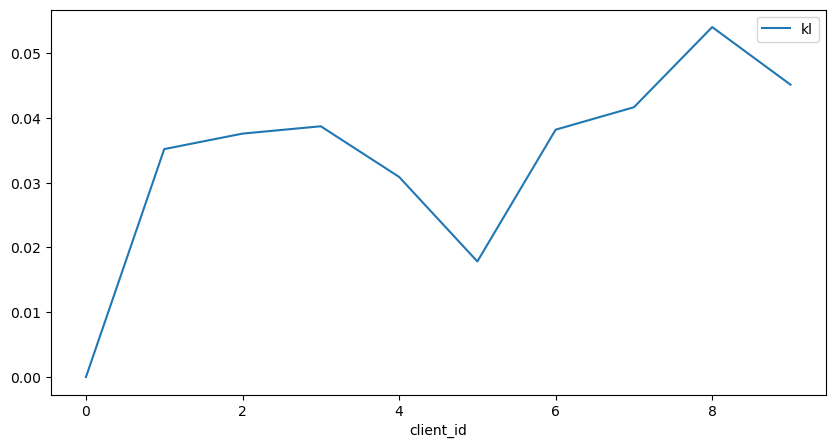

In [163]:
df_plot.set_index("client_id")["kl"].plot(legend=True, figsize=(10, 5))

#### Simple k-NN, p=0.25, M=6

<AxesSubplot:xlabel='client_id'>

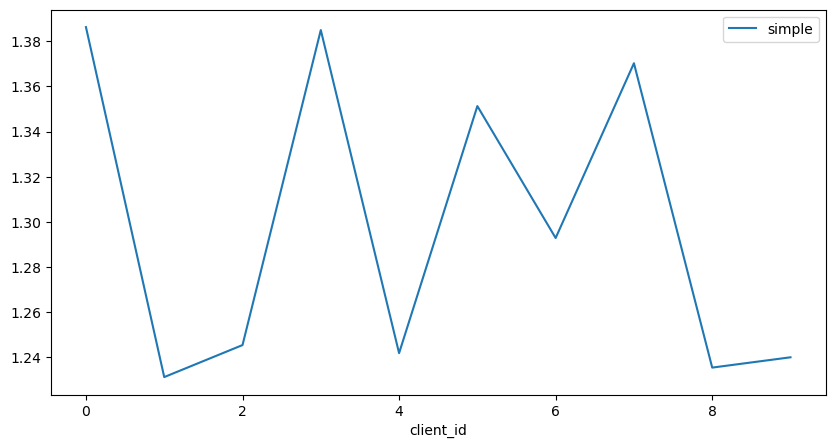

In [47]:
df_plot.groupby("client_id")["simple"].sum().plot(legend=True, figsize=(10, 5))

#### Gaussian Kernel k-NN, p=0.25, M=6 (seuclidian distance, sigma=1)

<AxesSubplot:xlabel='client_id'>

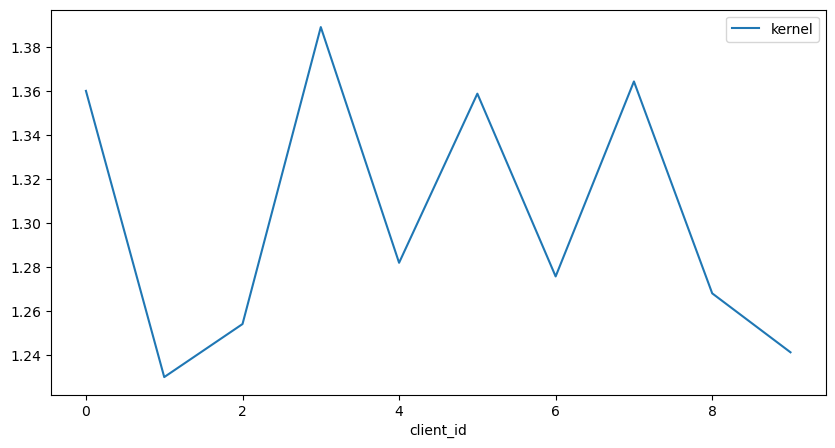

In [61]:
df_plot.groupby("client_id")["kernel"].sum().plot(legend=True, figsize=(10, 5))

#### Gaussian Kernel k-NN, p=0.25, M=6 (cosine distance, sigma=1)
> Important: Cosine distance very robust for difference sigma-values

<AxesSubplot:xlabel='client_id'>

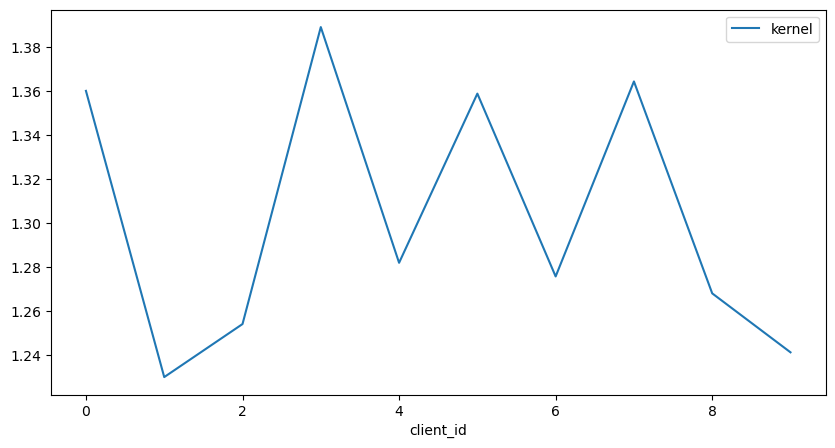

In [63]:
df_plot.groupby("client_id")["kernel"].sum().plot(legend=True, figsize=(10, 5))

#### Gaussian Kernel k-NN, p=0.75, M=6 (cosine distance, sigma=1)

<AxesSubplot:xlabel='client_id'>

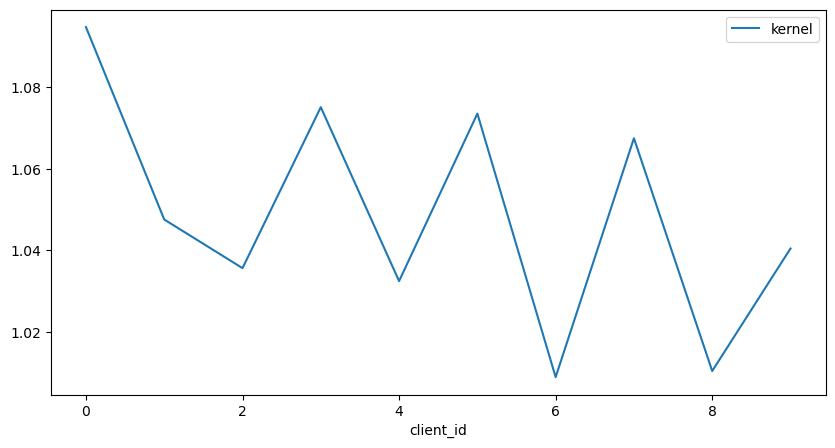

In [69]:
df_plot.groupby("client_id")["kernel"].sum().plot(legend=True, figsize=(10, 5))

#### Gaussian Kernel k-NN, p=0.75, M=8 (seuclidian distance, sigma=1)

<AxesSubplot:xlabel='client_id'>

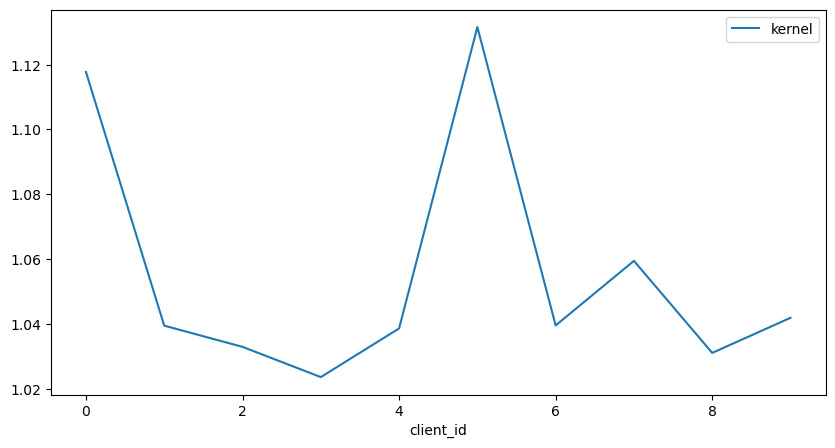

In [73]:
df_plot.groupby("client_id")["kernel"].sum().plot(legend=True, figsize=(10, 5))

## Non-IID Sampling

In [3]:
from torch.utils.data import Dataset

class PTB_XL(Dataset):
    def __init__(self, X, y, stage):
        self.stage = stage
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sample = self.X[idx].transpose((1, 0)), self.y[idx]
        return sample

In [4]:
"""
Data loading
"""
sampling_frequency = 100
datafolder = "/home/mohkoh/projects/Split_ECG_Classification/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"
task = "superdiagnostic"
mlb_path = "/home/mohkoh/projects/Split_ECG_Classification/.mlb.pkl"

# Load PTB-XL data
data, raw_labels = utils.load_dataset(datafolder, sampling_frequency)
# Preprocess label data
labels = utils.compute_label_aggregations(raw_labels, datafolder, task)
# Select relevant data and convert to one-hot
data, labels, Y, _ = utils.select_data(
    data, labels, task, min_samples=0, outputfolder=mlb_path
)
input_shape = data[0].shape
print(input_shape)

# 1-9 for training
X_train = data[labels.strat_fold < 10]
y_train = Y[labels.strat_fold < 10]
# 10 for validation
X_val = data[labels.strat_fold == 10]
y_val = Y[labels.strat_fold == 10]

num_classes = 5  # <=== number of classes in the finetuning dataset
input_shape = [
    1000,
    12,
]  # <=== shape of samples, [None, 12] in case of different lengths

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

standard_scaler = pickle.load(open("/home/mohkoh/projects/Split_ECG_Classification/standard_scaler.pkl", "rb"))

X_train = utils.apply_standardizer(X_train, standard_scaler)
X_val = utils.apply_standardizer(X_val, standard_scaler)

train_dataset = PTB_XL(X_train, y_train, stage="train")
val_dataset = PTB_XL(X_val, y_val, stage="val")

# divides the numpy array X_train into num_clients subsets of equal size
# subsets = torch.utils.data.random_split(
#     train_dataset,
#     [1 / N] * N,
#     generator=torch.Generator().manual_seed(42),
# )
# subsets = [(X_train[subset.indices], y_train[subset.indices]) for subset in subsets]

(1000, 12)
(19230, 1000, 12) (19230, 5) (2158, 1000, 12) (2158, 5)


/home/mohkoh/anaconda3/envs/Medical-Split-Learning/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [138]:
point_scale = len(X_train) // 10
client_scale = 2.5
challenge_frac = 0.05

In [139]:
samples = []

y_train_dec = np.sum(y_train * 2**np.arange(y_train.shape[1])[::-1], axis=1)
df_train = pd.DataFrame({"y": y_train_dec})
challenge = df_train.sample(n=int(len(df_train) * challenge_frac), replace=False)
df_train = df_train[~df_train.index.isin(challenge.index)].sort_values("y")


p = np.random.normal(N//2, client_scale, len(df_train))
p = p.round().clip(0, N-1).astype(int)
clients, counts = np.unique(p, return_counts=True)

for client_id in clients:
    loc = counts[:client_id].sum() + counts[client_id] // 2
    df_train[f"pdf_{client_id}"] = norm.pdf(df_train.index.sort_values().values, loc=loc, scale=point_scale)

for client_id in clients:    
    sample = df_train.sample(n=counts[client_id], weights=f"pdf_{client_id}", replace=False)
    df_train = df_train[~df_train.index.isin(sample.index)]
    #samples.append((X_train[sample.index.values], y_train[sample.index.values]))
    sample = pd.concat([sample, challenge], axis=0)
    samples.append(sample)


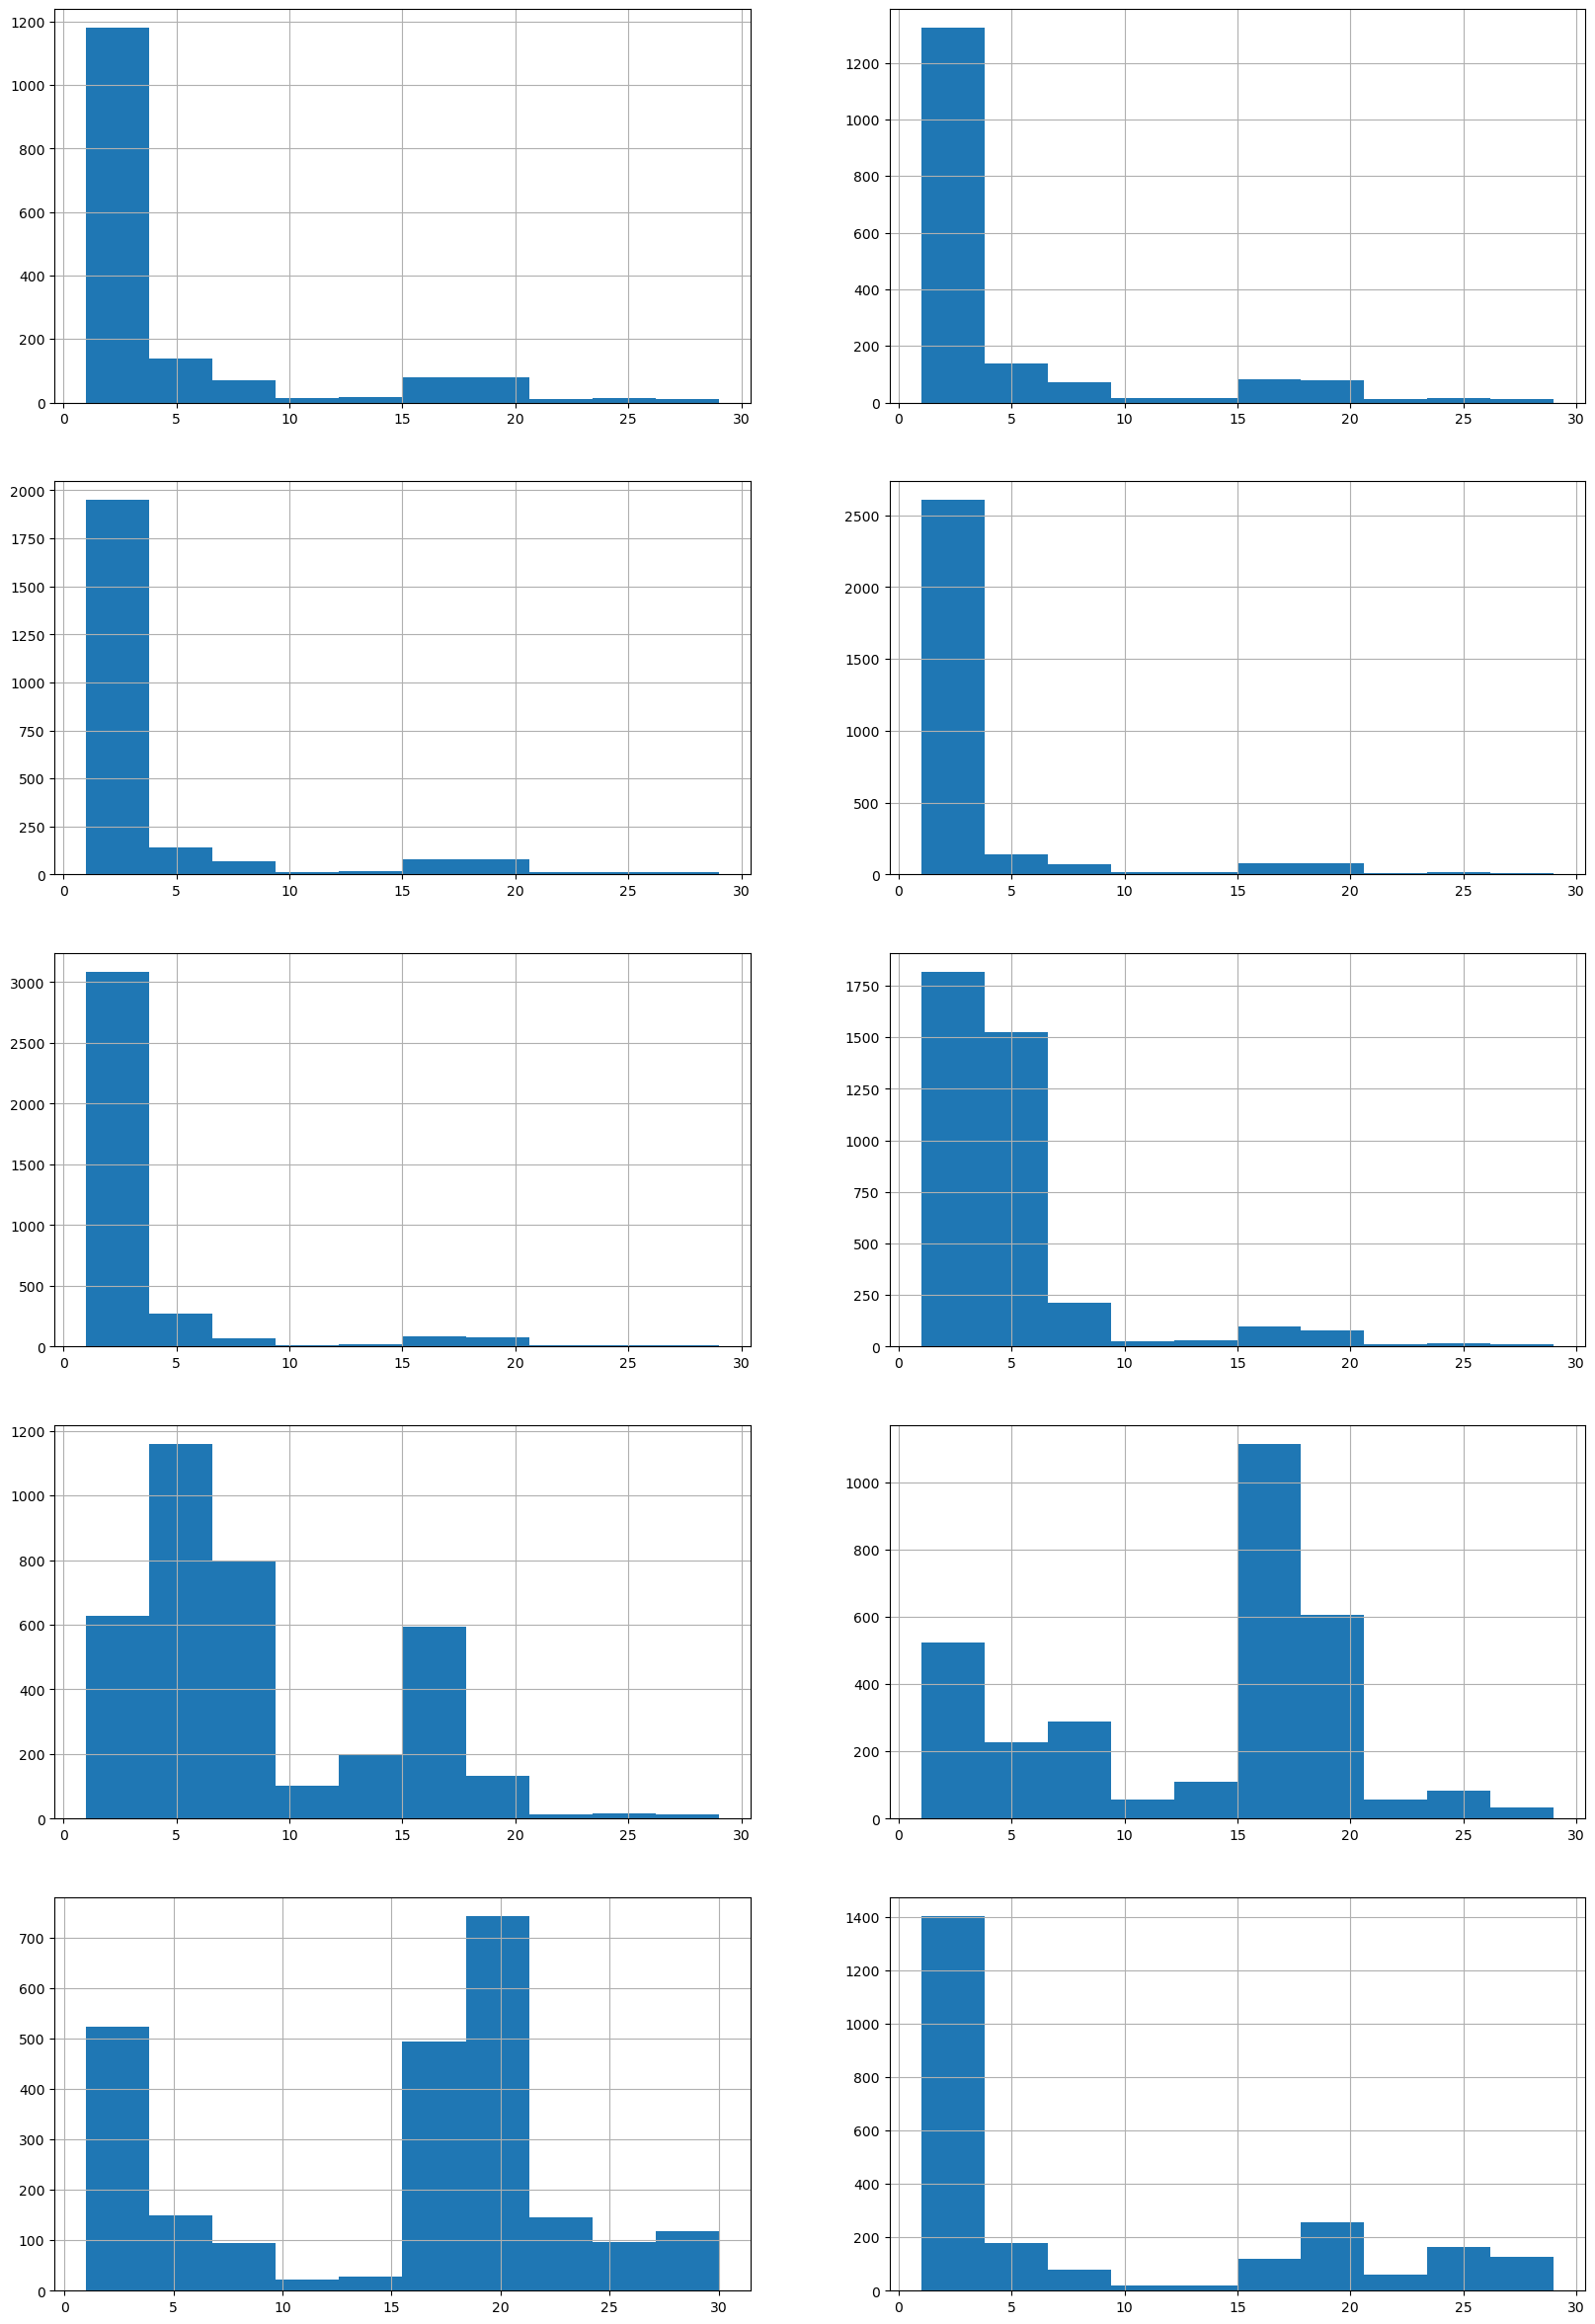

In [140]:
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(20, 30))
for client_id in clients:
    #plots histogram of the sample
    samples[client_id].y.hist(ax=ax[client_id // 2][client_id % 2])	


<AxesSubplot:>

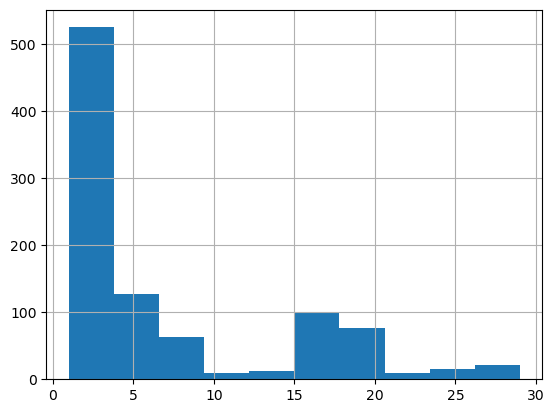

In [137]:
challenge.y.hist()	

## Non-IID adaptation

Compare at the end of each epoch considering the whole latent space. 

In [6]:
def simple_membership(nX, y):
    nY = y[nX]
    comp = nY[:, 0]
    p_k = (nY == comp[:, None]).sum(axis=1) / 10 - 1/10
    p_k = p_k / np.sum(p_k)
    # p_k = {k: p_k[y == k].mean() for k in np.unique(y)}
    # p_k = [p_k[y == k].mean() for k in np.unique(y)]
    # p_k = p_k / np.sum(p_k)
    # p_k = {k: p_k[i] for i, k in enumerate(np.unique(y))}
    return p_k

def kernel_membership(nX, dX, y, sigma=1.0):
    dY = np.exp(-(dX)[:, 1:] ** 2 / sigma ** 2)
    nY = y[nX]
    comp = nY[:, 0]
    nY = nY[:, 1:]
    p_k = (dY * (nY == comp[:, None])).sum(axis=1) / dY.sum(axis=1)
    p_k = p_k / np.sum(p_k)
    p_k = np.nan_to_num(p_k, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    # p_k = {k: p_k[y == k].mean() for k in np.unique(y)}
    # p_k = [p_k[y == k].mean() for k in np.unique(y)]
    # p_k = p_k / np.sum(p_k)
    # p_k = {k: p_k[i] for i, k in enumerate(np.unique(y))}
    return p_k

def pack_probs(p_k, y):
    p_k = {k: p_k[y == k].sum() for k in np.unique(y)}
    # p_k = [p_k[y == k].sum() for k in np.unique(y)]
    # p_k = p_k / np.sum(p_k)
    # p_k = {k: p_k[i] for i, k in enumerate(np.unique(y))}
    return p_k

In [7]:
def client_score(epoch):
    # For each client i, we comupte the membership probability p_k for each class k. But we consider all points in Z_t, not only the ones from client i.
    df_scores = pd.DataFrame(columns=["epoch", "client_id", "label", "num_samples", "simple", "kernel"])
    
    # Let the epoch be t = 1 
    df_t = df_base[df_base["epoch"] == epoch]
    df_t = df_t[df_t.stage == "train"]
    df_t = split_labels(df_t, split)
    df_t.client_output = pool_latent_vectors(df_t.client_output.to_list(), pooling=pooling).tolist()
    df_t.reset_index(drop=True, inplace=True)

    # The latent space Z_t is the output of each client at epoch t 
    Z_t = np.array(df_t.client_output.to_list())
    y = df_t.label.to_numpy()
    client_ids = df_t.client_id.to_numpy()
        
    neigh = KNeighborsClassifier(**knn_params)
    neigh.fit(Z_t, y)
    dX, nX = neigh.kneighbors(Z_t, return_distance=True)
    simple, kernel = simple_membership(nX, y), kernel_membership(nX, dX, y, sigma=sigma)

    for client_id in tqdm(range(N), desc=f"Client", leave=False):
        idx = client_ids == client_id
        simple_, kernel_ = pack_probs(simple[idx], y[idx]), pack_probs(kernel[idx], y[idx])

        for k in simple_.keys():
            df_scores.loc[len(df_scores)] = [epoch, client_id, k, (y[idx] == k).sum(), simple_[k], kernel_[k]]
            
    sum_samples = df_scores.groupby("label")["num_samples"].sum()
    df_scores["sum_samples"] = df_scores["label"].map(sum_samples)
    
    return df_scores

In [ ]:
df_scores = pd.DataFrame(columns=["epoch", "client_id", "label", "num_samples", "simple", "kernel"])

# Compute in parallel
with closing(multiprocessing.Pool(processes=multiprocessing.cpu_count())) as p:
    with tqdm(total=epochs, desc=f"Epoch") as pbar:
        for r in p.imap_unordered(client_score, range(1, epochs + 1)):
            df_scores = pd.concat([df_scores, r], ignore_index=True, copy=False)
            pbar.update()
p.join()


In [326]:
df_scores.kernel = df_scores.kernel.astype(float)
df_scores.simple = df_scores.simple.astype(float)

client_id
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cum_div, dtype: object

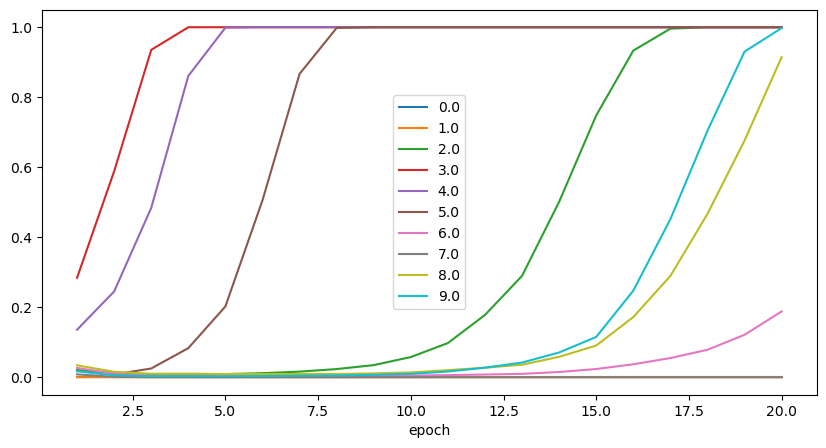

In [330]:
df_plot = rolling_membership_diff(df_scores, ref=None, method="kernel")
#df_plot["cum_div"] = df_plot.groupby("client_id")["skl"].transform(pd.Series.cumsum)
# df_plot["cum_div"] = df_plot.groupby("client_id")["skl"].transform(lambda x: x.rolling(window=20, min_periods=0, center=False).sum())
df_plot["cum_div"] = df_plot.groupby("client_id")["skl"].transform(lambda x: x.ewm(halflife=15).sum())
df_plot = df_plot.apply(lambda x: exp_decay(x), axis=1)
df_plot["cum_div"][df_plot["cum_div"] < 0] = 0
#df_plot["cum_div"] = df_plot.groupby("epoch")["cum_div"].transform(lambda x: 1 - np.exp(-x**2))
df_plot[df_plot.epoch < 30].set_index("epoch").groupby("client_id")["cum_div"].plot(legend=True, figsize=(10, 5))

In [212]:
df_plot

,epoch,client_id,norm
0,1.0,0.0,0.074059
1,1.0,1.0,0.057105
2,1.0,2.0,0.021577
3,1.0,3.0,0.067723
4,1.0,4.0,0.035939
...,...,...,...
195,20.0,5.0,0.045203
196,20.0,6.0,0.032170
197,20.0,7.0,0.034562
198,20.0,8.0,0.018941


In [1]:
def simple_membership(nX, y):
    nY = y[nX]
    comp = nY[:, 0]
    p_k = (nY == comp[:, None]).sum(axis=1) / 10 - 1/10
    # p_k = {k: p_k[y == k].mean() for k in np.unique(y)}
    # p_k = [p_k[y == k].mean() for k in np.unique(y)]
    # p_k = p_k / np.sum(p_k)
    # p_k = {k: p_k[i] for i, k in enumerate(np.unique(y))}
    return p_k

def kernel_membership(nX, dX, y, sigma=1.0):
    dY = np.exp(-(dX)[:, 1:] ** 2 / sigma ** 2)
    nY = y[nX]
    comp = nY[:, 0]
    nY = nY[:, 1:]
    p_k = (dY * (nY == comp[:, None])).sum(axis=1) / dY.sum(axis=1)
    p_k = np.nan_to_num(p_k, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    # p_k = {k: p_k[y == k].mean() for k in np.unique(y)}
    # p_k = [p_k[y == k].mean() for k in np.unique(y)]
    # p_k = p_k / np.sum(p_k)
    # p_k = {k: p_k[i] for i, k in enumerate(np.unique(y))}
    return p_k


In [129]:
def nn_kl_div(epoch):
    df_plot = pd.DataFrame(columns=["epoch", "client_id", "num_samples", "re", "kl", "skl"])

    # Let the epoch be t = 1, pre-process data
    df_t = df_base[df_base["epoch"] == epoch]
    df_t = df_t[df_t.stage == "train"]
    df_t = split_labels(df_t, split)
    df_t.client_output = pool_latent_vectors(df_t.client_output.to_list(), pooling=pooling).tolist()
    df_t.reset_index(drop=True, inplace=True)

    # The latent space Z_t is the output of each client at epoch t 
    Z_t = np.array(df_t.client_output.to_list())
    y = df_t.label.to_numpy()
    client_ids = df_t.client_id.to_numpy()

    # Build KNN model
    neigh = KNeighborsClassifier(**knn_params)
    neigh.fit(Z_t, y)
    dX, nX = neigh.kneighbors(Z_t, return_distance=True)

    nC = client_ids[nX]
    compC = nC[:, 0]
    nY = y[nX]
    compY = nY[:, 0]

    p_k = (nY == compY[:, None]).sum(axis=1) / 10

    # for client_id in np.unique(client_ids):
    #     p_k[client_ids == client_id] = p_k[client_ids == client_id] / p_k[client_ids == client_id].sum()

    # p_k = p_k / np.sum(p_k)
    

    # select_id = ((nY == compY[:, None]) & (nC != compC[:, None])).argmax(axis=1)
    select_id = ((nY == compY[:, None]) & (nC == 6)).argmax(axis=1)
    q_k = p_k[np.choose(select_id, nX.T)]
    d_k = np.choose(select_id, dX.T)
    print(d_k)
    d_k = np.exp(- d_k) 
    # d_k = d_k / d_k.max() #(d_k - d_k.min()) / (d_k.max() - d_k.min()) 
    print(d_k)
    
    #q_k = q_k * np.exp(-(d_k) ** 2 / sigma ** 2)
    # q_k = q_k * d_k

    kl = kl_div(p_k, q_k)# * d_k
    re = rel_entr(p_k, q_k)# * d_k
    skl = (kl + kl_div(q_k, p_k))# * d_k
    
    for client_id in tqdm(range(N), desc=f"Client", leave=False):
        idx = client_ids == client_id
        td = np.array([re[idx].sum(), kl[idx].sum(), skl[idx].sum()]) / idx.sum()
        df_plot.loc[len(df_plot)] = [epoch, client_id, idx.sum(), *td]
        
    return df_plot

In [96]:
nn_kl_div(15)

[0.         1.64573292 1.49104065 ... 1.97978402 2.77134279 4.08127018]
[1.         0.19287115 0.22513824 ... 0.13809906 0.06257792 0.016886  ]


Client:   0%|          | 0/10 [00:00<?, ?it/s]

,epoch,client_id,num_samples,re,kl,skl
0,15.0,0.0,704.0,19.870707,27.070707,53.741481
1,15.0,1.0,832.0,42.213464,31.413464,61.133513
2,15.0,2.0,1472.0,33.585026,44.985026,90.558986
3,15.0,3.0,2112.0,34.421674,64.121674,128.722364
4,15.0,4.0,2688.0,40.115409,86.615409,174.958220
5,15.0,5.0,3072.0,62.336789,112.436789,225.634207
6,15.0,6.0,2752.0,69.163234,95.063234,187.705597
7,15.0,7.0,2304.0,65.522342,78.422342,153.720020
8,15.0,8.0,1472.0,8.375952,61.275952,126.431035
9,15.0,9.0,1536.0,10.110541,53.410541,109.178230


In [130]:
nn_kl_div(10)

[0.         0.         0.         ... 3.46704468 0.         0.        ]
[1.         1.         1.         ... 0.03120913 1.         1.        ]


Client:   0%|          | 0/10 [00:00<?, ?it/s]

,epoch,client_id,num_samples,re,kl,skl
0,10.0,0.0,704.0,0.013549,0.007299,0.013651
1,10.0,1.0,832.0,0.018410,0.007833,0.014450
2,10.0,2.0,1472.0,0.013785,0.007671,0.014855
3,10.0,3.0,2112.0,0.011163,0.006523,0.012785
4,10.0,4.0,2688.0,0.016791,0.009425,0.018168
5,10.0,5.0,3072.0,0.024976,0.021753,0.042464
6,10.0,6.0,2752.0,0.000000,0.000000,0.000000
7,10.0,7.0,2304.0,0.039266,0.023684,0.044705
8,10.0,8.0,1472.0,0.025309,0.015731,0.030699
9,10.0,9.0,1536.0,0.017694,0.010793,0.020802


In [124]:
df_t = df_base[df_base["epoch"] == epoch]
df_t = df_t[df_t.stage == "train"]
df_t = split_labels(df_t, split)
df_t[df_t.client_id == 3].label.value_counts()

2.0    1931
1.0     177
4.0       4
Name: label, dtype: int64

In [82]:
np.exp(- (1 - d_k)).min()

0.36787944117144233

In [59]:
v = np.linspace(.001, 1, 100)
#v = (v - v.min()) / (v.max() - v.min() )
#v = v / v.max()
np.exp(-v)

array([0.9990005 , 0.98897037, 0.97904094, 0.96921121, 0.95948016,
       0.94984682, 0.9403102 , 0.93086933, 0.92152325, 0.912271  ,
       0.90311165, 0.89404426, 0.8850679 , 0.87618167, 0.86738466,
       0.85867598, 0.85005473, 0.84152004, 0.83307104, 0.82470686,
       0.81642667, 0.80822961, 0.80011485, 0.79208156, 0.78412893,
       0.77625615, 0.76846241, 0.76074691, 0.75310889, 0.74554755,
       0.73806213, 0.73065186, 0.723316  , 0.71605378, 0.70886448,
       0.70174737, 0.6947017 , 0.68772678, 0.68082189, 0.67398633,
       0.66721939, 0.6605204 , 0.65388866, 0.64732351, 0.64082428,
       0.63439029, 0.62802091, 0.62171547, 0.61547335, 0.60929389,
       0.60317648, 0.59712049, 0.5911253 , 0.5851903 , 0.57931489,
       0.57349848, 0.56774046, 0.56204025, 0.55639727, 0.55081095,
       0.54528071, 0.539806  , 0.53438626, 0.52902094, 0.52370948,
       0.51845135, 0.51324601, 0.50809293, 0.5029916 , 0.49794148,
       0.49294206, 0.48799284, 0.48309331, 0.47824297, 0.47344

In [72]:
df_plot = pd.DataFrame()

# Compute in parallel
with closing(multiprocessing.Pool(processes=multiprocessing.cpu_count() // 2)) as p:
    with tqdm(total=epochs, desc=f"Epoch") as pbar:
        for r in p.imap_unordered(nn_kl_div, range(1, epochs + 1)):
            df_plot = pd.concat([df_plot, r], ignore_index=True, copy=False)
            pbar.update()
p.join()


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

In [73]:
df_tmp = df_plot.copy()

In [74]:
df_plot = df_tmp.copy()

In [77]:
df_plot["skl"] = df_plot["skl"].divide(df_plot["num_samples"])
df_plot["kl"] = df_plot["kl"].divide(df_plot["num_samples"])

In [78]:
df_plot["re"] = df_plot["re"].divide(df_plot["num_samples"])

In [75]:
df_plot

,epoch,client_id,num_samples,re,kl,skl
0,7.0,0.0,704.0,41.267203,24.337565,47.113600
1,7.0,1.0,832.0,49.027485,28.629831,55.253723
2,7.0,2.0,1472.0,74.001876,46.264301,90.777529
3,7.0,3.0,2112.0,113.990624,63.175711,125.288051
4,7.0,4.0,2688.0,76.608443,80.816946,161.438971
...,...,...,...,...,...,...
295,28.0,5.0,3072.0,140.196471,111.340406,218.476090
296,28.0,6.0,2752.0,99.916350,90.164955,176.346327
297,28.0,7.0,2304.0,63.941438,72.280117,142.104460
298,28.0,8.0,1472.0,25.712723,53.055463,107.632295


client_id
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cum_div, dtype: object

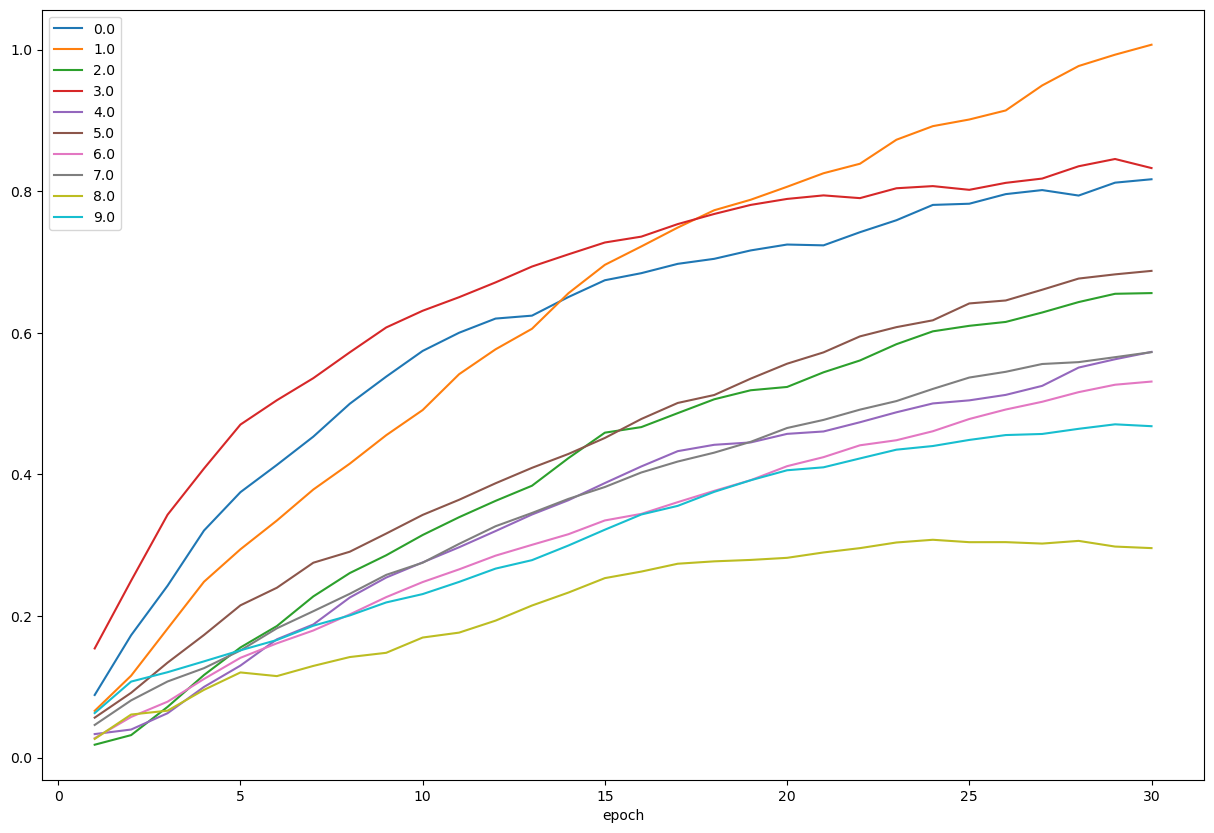

In [79]:
df_plot = df_plot.sort_values(by="epoch")
#df_plot["cum_div"] = df_plot.groupby("client_id")["skl"].transform(pd.Series.cumsum)
# df_plot["cum_div"] = df_plot.groupby("client_id")["skl"].transform(lambda x: x.rolling(window=20, min_periods=0, center=False).sum())
df_plot["cum_div"] = df_plot.groupby("client_id")["re"].transform(lambda x: x.ewm(halflife=15).sum())
#df_plot = df_plot.apply(lambda x: exp_decay(x), axis=1)
df_plot["cum_div"][df_plot["cum_div"] < 0] = 0
#df_plot["cum_div"] = df_plot.groupby("epoch")["cum_div"].transform(lambda x: 1 - np.exp(-x**2))
df_plot.set_index("epoch").groupby("client_id")["cum_div"].plot(legend=True, figsize=(15, 10))

In [216]:
(p_k - q_k).max()

0.9000000000000001

In [ ]:
d_k_norm = dk / dk.sum()

In [211]:
pd.Series(d_k).max()

17.009294484676982

In [ ]:
def rolling_membership_diff_non_iid(df_base, method="kernel", ref=None, div="skl"):
    df_plot = pd.DataFrame(columns=["epoch", "client_id", "re", "kl", "sre", "skl"])
    P = lambda X, c: X[X.client_id == c].sort_values("label")
    
    old_p_k = None
    df_old = None
    for epoch in df_base.epoch.sort_values().unique():
        df = df_base[df_base.epoch == epoch]
    
        if ref is not None:
            old_p_k = P(df, ref)
            
        for client_id in df_base.client_id.sort_values().unique():    
            
            if df_old is not None and ref is None:
                old_p_k = P(df_old, client_id)
            else:
                old_p_k = P(df, client_id)
            
            p_k = P(df, client_id)
            
            p_k = p_k[p_k.label.isin(old_p_k.label)]
            old_p_k = old_p_k[old_p_k.label.isin(p_k.label)]
            

            # ratio = p_k.num_samples.values / old_p_k.num_samples.values
            # ratio2 = old_p_k.num_samples.values / p_k.num_samples.values
            
            # p = old_p_k[method].values * ratio
            # p = p / np.sum(p)
            # q = p_k[method].values * ratio2
            # q = q / np.sum(q)
                        
            # kl = kl_div(p, q).sum() 
            # re = rel_entr(p, q).sum()
            # kl_2 = kl_div(q, p).sum() 
            # re_2 = rel_entr(q, p).sum() 
            
            # skl = kl + kl_2
            # sre = re + re_2
            
            p = old_p_k[method].values
            q = p_k[method].values
                                    
            kl = kl_div(p, q).sum()
            re = rel_entr(p, q).sum()
            skl = kl + kl_div(q, p).sum()
            sre = re + rel_entr(q, p).sum()
            
            td = [re, kl, sre, skl]
                        
            df_plot.loc[len(df_plot)] = [epoch, client_id, *td]
        df_old = df
                    
    return df_plot